# Optimizing Plane Boarding Processes
By Marion Madanguit and Zachary Sherman

In [11]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *

# set the random number generator
np.random.seed(7)

import pandas as pd
import numpy as np
import random
import matplotlib as plt

## Question
As the old adage says, “An airplane doesn’t make money sitting on the ground.” One reason planes sit on the ground is because they are loading passengers and carry-on bags. With our model, our primary goal is to help commercial flight operators optimize their boarding processes by testing three of the most popular methods with varying amounts of carry-on bags. By finding an answer to this design question, we aim to help airlines board passengers in the fastest way possible, maximizing their profits and minimizing the time their planes spend at gates.

## Model

To answer this question, we will model three different boarding methods: random, back-to-front, and WILMA (window-middle-aisle), then compare the average amount of time delay per passenger. We will also generate a “queue” (representing a line of ordered passengers in the jet bridge) for each boarding method. The model will begin with an empty plane that has 25 rows of six seats each and a state parameter that keeps track of the number of empty seats, the number of full seats, and the average amount of time delay per passenger (each initially at 0). The model will then seat each passenger, one by one, using the specified order queue.

There are two elements that we chose to factor into delay time: whether or not the passenger being seated has a carry-on bag, and whether or not another passenger is blocking their seat. If the passenger has a carry-on bag, it takes them some time to put it in the overhead bin. If another passenger is blocking their seat, it takes time for them to get up and switch places. Time delays were determined by the number of physical movements that went into each action. The time delay that each passenger causes increases the plane’s total boarding time, and this is reflected in our model. Once the passenger has been seated, each parameter is updated. The model runs until each passenger has been seated, then records the average amount of time delay per passenger. 

We are making several assumptions in this model. First, the time delay is based on the number of physical movements that we counted for each action. For example, if a passenger has a carry-on bag, they must bend down to pick up the bag, lift the bag over their head, place the bag in the overhead bin, and get back to normal position. We counted this as a total of six physical movements which equated to six time units. There is no real unit of time associated with this. However, because we are consistent with this when we run through each boarding method, we end up with data that is useful in comparing each boarding method. We also focus on only two of the factors that impact time delay: carry-on bags and passengers seated in the way. We chose these factors based on the significance of their impact on time delay and on how feasible it was to model them given our current skill set and time frame.

The code for our model is below.

In [6]:
# Time delay multiplier based on how long it takes passenge to put luggage in overhead cabin
time_delay_luggage = 6

# Time delays for when passenger who has window or middle seat needs to have passenger in middle or aisle seat get up for them
time_delay_middle = 8
time_delay_aisle = 6

# Create a list of plane seats and randomize it
def create_random_queue(x,y):
    random_queue = []
    for i in range(x):
        for j in range(y):
            random_queue.append([i,j])
    random.shuffle(random_queue)
    return random_queue

# Create a list of plane seats and organize it Back-To-Front
def create_btf_queue(x,y):
    btf_queue = []
    for i in range(x):
        for j in range(y):
            btf_queue.append([i,j])
    btf_queue.reverse()
    return btf_queue

# Create a list of plane seats and organize it Window-Middle-Aisle
def create_wilma_queue(x,y):
    wilma_queue = []
    for i in range(0, y // 2, 1):
        for j in range(x):
            wilma_queue.append([j,i])
    for i in range(y - 1, y // 2 - 1, -1):
        for j in range(x):
            wilma_queue.append([j,i])
    return wilma_queue

# Go through selected list, seat each passenger, and return total delay time
def run_simulation(queue, x, y, probability_luggage):

    # Make an empty "plane" with specified dimensions
    plane = np.zeros((x,y))

    state = State(empty_seats = np.count_nonzero(plane == 0),
                  full_seats = np.count_nonzero(plane == 1),
                  delay_time = 0)

    for k in range(len(queue)):
        select_x = queue[k][0]
        select_y = queue[k][1]

        if (plane[select_x][select_y] == 0):

            pass_delay = 0
            num_behind = 0

            # Time delay if passenger has luggage
            if (flip(probability_luggage)):
                    pass_delay += time_delay_luggage

            # Time delay if passenger who has window or middle seat needs to have passenger in middle or aisle seat get up for them
            if (select_y == 0):
                if (plane[select_x][1] == 1):
                    pass_delay += time_delay_middle
                if (plane[select_x][2] == 1):
                    pass_delay += time_delay_aisle
            if (select_y == 1):
                if (plane[select_x][2] == 1):
                    pass_delay += time_delay_aisle
            if (select_y == 5):
                if (plane[select_x][4] == 1):
                    pass_delay += time_delay_middle
                if (plane[select_x][3] == 1):
                    pass_delay += time_delay_aisle
            if (select_y == 4):
                if (plane[select_x][3] == 1):
                    pass_delay += time_delay_aisle

            for i in range(select_x, x):
                for j in range(0, y):
                    if (plane[i,j] == 0):
                        num_behind += 1

            state.delay_time += num_behind * pass_delay

            # Mark seat as filled
            plane[select_x][select_y] = 1

            # Update number of seated passengers
            state.empty_seats -= 1
            state.full_seats += 1

    state.delay_time = state.delay_time / float(x * y)
    return state.delay_time

## Results
To answer our initial question, we ran our stimulation for 5 different starting positions and plotted the motion of the two masses over Our results allowed us to plot 

To answer the parameter smoothing question, we then want to run this simulation for all values of $k$. This requires choosing a starting configuration. For simplicity, we will assume that there are 600 bikes available (10% of the total number in 2013 reflecting roughly the proportion of trips that our data includes) and will consider all possible configurations with a multiple of 200 bikes starting at each station. This allows us to compare the models for several different starting configurations. We plot the results for the (200, 200, 200) starting configuration and give the remaining results in a table below. 

We then ran our simulation through all three boarding methods at varying probabilities that a passenger has a carry-on bag. We tested carry-on bag probabilities from 0% to 100%, with 1% precision. Running our model outputs a graph of average time delay vs. probability that each passenger has a carry-on bag. Data for each boarding method is plotted on the same graph to allow for easy comparison.

      Random  BTF  Wilma
0.00      94    4      0
0.01      95    4      0
0.02     100    4      1
0.03     108    5     10
0.04      97    5     17
...      ...  ...    ...
0.95     342   24    242
0.96     338   24    260
0.97     343   24    272
0.98     351   25    268
0.99     350   24    271

[100 rows x 3 columns]


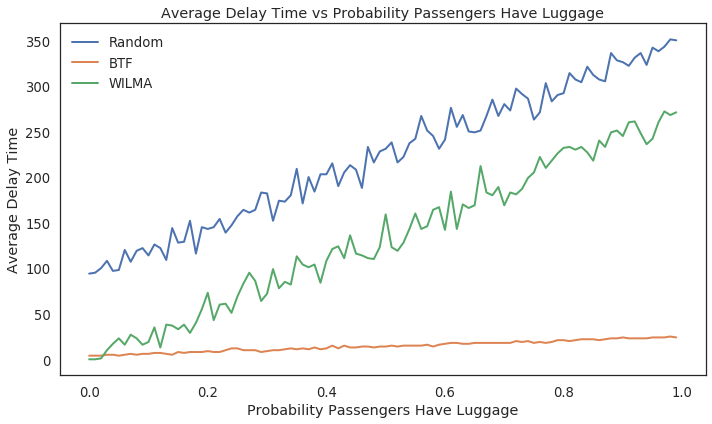

In [13]:
# Generate luggage probabilities
probabilities_luggage = linrange(0, 1, 0.01)

# Create sweep series object for each boarding method
rand_sweep = SweepSeries()
btf_sweep = SweepSeries()
wilma_sweep = SweepSeries()

# Create queues
random_queue = create_random_queue(25,6)
btf_queue = create_btf_queue(25,6)
wilma_queue = create_wilma_queue(25, 6)

# Run simulation through all three boarding methods at varying probabilities that a passenger has a carry-on bag
for z in probabilities_luggage:
    rand_final_state = run_simulation(random_queue, 25, 6, z)
    rand_sweep[z] = rand_final_state

    btf_final_state = run_simulation(btf_queue, 25, 6, z)
    btf_sweep[z] = btf_final_state

    wilma_final_state = run_simulation(wilma_queue, 25, 6, z)
    wilma_sweep[z] = wilma_final_state

rand_series = pd.Series(rand_sweep, name='Random')
btf_series = pd.Series(btf_sweep, name='BTF')
wilma_series = pd.Series(wilma_sweep, name='Wilma')

frame = pd.concat([rand_series, btf_series, wilma_series], axis=1)

def make_plot(series, linelabel, title, xlabel, ylabel):
    plot(series, label=linelabel)
    decorate(title=title, xlabel=xlabel, ylabel=ylabel)

# Plot data
plt.rcParams["figure.figsize"] = (10, 6)

make_plot(frame['Random'], 'Random', 'Average Delay Time vs Probability Passengers Have Luggage', 'Probability Passengers Have Luggage', 
          'Average Delay Time')
make_plot(frame['BTF'], 'BTF', 'Average Delay Time vs Probability Passengers Have Luggage', 'Probability Passengers Have Luggage', 
          'Average Delay Time')
make_plot(frame['Wilma'], 'WILMA', 'Average Delay Time vs Probability Passengers Have Luggage', 'Probability Passengers Have Luggage', 
          'Average Delay Time')

print(frame)

## Interpretation
Our graph presents a clear result: seating passengers back-to-front is the fastest way to board a plane. For the vast majority of probabilities that a passenger has a carry-on bag, back-to-front seating would be the recommended method for airlines to choose, given its speed. This makes sense because in the back-to-front seating method, no passengers are trying to get past the row being seated and so delay times are not compounded like the other methods. The only time that it was not the most efficient method was when there were close to no bags on the plane. In that event, WILMA seating was the fastest method. This said, our model is severely limited. First, it only takes into account single passengers and their carry-on bags. In reality, many factors impact passenger delay. For example, passengers with kids may need more time to board to organize sitting together, and elderly groups may take longer than others. Our delay time data is also not accurate. To construct a fully completed model, accurate delay times with real-world tests would be necessary. It is important to note that we have only tested one plane design (Airbus A320 seating arrangement) and that it is quite possible that different plane designs (Boeing 737, which has a 3-5-3 seating arrangement, Embraer E190, which has a 2-2 seating arrangement, or others) would benefit from different boarding methods. In the future, more research should be completed to determine the fastest boarding methods for other aircraft.